# Proyecto final: **Bank Churn Prediction**

In [2]:
import requests
import pandas as pd
from io import StringIO
import time 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, chi2

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score

In [3]:
url="/workspaces/Isa-Project/data/friance new.csv"
data_raw=pd.read_csv(url)
data_raw.head()

/tmp/ipykernel_737/317681209.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw=pd.read_csv(url)


,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,2023,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,...,1,0,0,0,1,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0
1,2024,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,...,1,0,0,0,1,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0
2,1236,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,...,1,0,0,0,1,0.0,0.0,0.0,0.25,400.0
3,1362,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,...,1,0,0,0,1,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0
4,491,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,...,0,0,1,0,1,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0


In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175028 entries, 0 to 175027
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Surname             175028 non-null  int64  
 1   CreditScore         175028 non-null  float64
 2   Age                 175028 non-null  float64
 3   Tenure              175028 non-null  float64
 4   Balance             175028 non-null  float64
 5   NumOfProducts       175028 non-null  float64
 6   HasCrCard           175028 non-null  int64  
 7   IsActiveMember      175028 non-null  int64  
 8   EstimatedSalary     175028 non-null  object 
 9   Exited              175028 non-null  int64  
 10  Surname_tfidf_0     175028 non-null  object 
 11  Surname_tfidf_1     175028 non-null  object 
 12  Surname_tfidf_2     175028 non-null  object 
 13  Surname_tfidf_3     175028 non-null  object 
 14  Surname_tfidf_4     175028 non-null  object 
 15  France              175028 non-nul

Duplicados y nulos

In [5]:
print(f"Duplicados: {data_raw.duplicated().sum()} Como existen duplicados, los eliminamos")
data_raw.drop_duplicates(inplace=True)
print(f"Comprobamos que ya no existen duplicados: {data_raw.duplicated().sum()}")

print(f"Nulos:\n{data_raw.isna().sum()} \n\nNo existen nulos en ninguna variable")

Duplicados: 41 Como existen duplicados, los eliminamos
Comprobamos que ya no existen duplicados: 0
Nulos:
Surname               0
CreditScore           0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Surname_tfidf_0       0
Surname_tfidf_1       0
Surname_tfidf_2       0
Surname_tfidf_3       0
Surname_tfidf_4       0
France                0
Germany               0
Spain                 0
Female                0
Male                  0
Mem__no__Products     0
Cred_Bal_Sal          0
Bal_sal               0
Tenure_Age            0
Age_Tenure_product    0
dtype: int64 

No existen nulos en ninguna variable


Vamos a realizar un EDA:

**Descripción de las variables:**

* **Surname** Apellido del cliente.- **Tipo**: int 

* **CreditScore** Puntuación de crédito, una medida de la solvencia crediticia. **Tipo**: float

* **Age** Edad del cliente. **Tipo**: float

* **Tenure** Número de años que el cliente ha sido cliente del banco. **Tipo**: float

* **Balance** Saldo de la cuenta del cliente. **Tipo**: float

* **NumOfProducts** Número de productos financieros que el cliente tiene con el banco. **Tipo**: float

* **IsActiveMember** Indica si el cliente es miembro activo (1 si lo es, 0 si no). **Tipo**: int

* **HasCrCard** Indica si el cliente tiene una tarjeta de crédito (1 si tiene, 0 si no). **Tipo**: int

* **EstimatedSalary** Salario estimado del cliente. **Tipo**: object - ***transformar***

* **Surname_tfidf_0 a Surname_tfidf_4** Características de procesamiento de texto (TF-IDF) derivadas del apellido del cliente. **Tipo**: object

* **France, Germany, Spain**: Variables dummy que indican la nacionalidad del cliente. **Tipo**: int

* **Female, Male** Variables dummy que indican el género del cliente. **Tipo**: int

* **Exited** Variable objetivo, indica si el cliente ha abandonado el servicio (1, 0 no). **Tipo**: int


**Las siguientes variables, pueden representar la relación entre variables arriba descritas, debemos analizar bien esa relación (posteriormente en el EDA lo vemos):**

* **Mem__no__Products** Una característica derivada que puede representar la relación entre el número de productos y la membresía activa. **Tipo**: float

* **Cred_Bal_Sal** Una característica derivada que puede representar la relación entre el puntaje de crédito, el saldo y el salario estimado. **Tipo**: object - ***transformar***

* **Bal_sal** Una característica derivada que puede representar la relación entre el saldo y el salario estimado. **Tipo**: object - ***transformar***

* **Tenure_Age** Una característica derivada que puede representar la relación entre la antigüedad y la edad del cliente. **Tipo**: object - ***transformar***

* **Age_Tenure_product** Una característica derivada que puede representar la relación entre la edad, la antigüedad y el número de productos. **Tipo**: float


Análisis de variables

* **Age** Edad del cliente. **Tipo**: float

* **Tenure** Número de años que el cliente ha sido cliente del banco. **Tipo**: float

* **NumOfProducts** Número de productos financieros que el cliente tiene con el banco. **Tipo**: float

* **IsActiveMember** Indica si el cliente es miembro activo (1 si lo es, 0 si no). **Tipo**: int

* **Female, Male** Variables dummy que indican el género del cliente. **Tipo**: int

* **Tenure_Age** Una característica derivada que puede representar la relación entre la antigüedad y la edad del cliente. **Tipo**: object - ***transformar***

* **Age_Tenure_product** Una característica derivada que puede representar la relación entre la edad, la antigüedad y el número de productos. **Tipo**: float

* **Mem__no__Products** Una característica derivada que puede representar la relación entre el número de productos y la membresía activa. **Tipo**: float

In [6]:
var1=["Age","Tenure","NumOfProducts","IsActiveMember","Female","Male","Tenure_Age","Age_Tenure_product","Mem__no__Products"]
var1_y="Exited"

data1=data_raw[var1]
data1.head()
data1['Tenure_Age'] = data1['Tenure_Age'].str.replace('.', '').str.replace(',', '.').astype(float)

y=data_raw[var1_y]

/tmp/ipykernel_737/4156906045.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Tenure_Age'] = data1['Tenure_Age'].str.replace('.', '').str.replace(',', '.').astype(float)


In [7]:
data1.head()

,Age,Tenure,NumOfProducts,IsActiveMember,Female,Male,Tenure_Age,Age_Tenure_product,Mem__no__Products
0,33.0,3.0,2.0,0,0,1,9.090909e+15,99.0,0.0
1,33.0,1.0,2.0,1,0,1,3.030303e+16,33.0,2.0
2,40.0,10.0,2.0,0,0,1,2.500000e+01,400.0,0.0
3,34.0,2.0,1.0,1,0,1,5.882353e+16,68.0,1.0
4,33.0,5.0,2.0,1,0,1,1.515152e+16,165.0,2.0


Vamos a analizar la **variable objetivo** **EXITED** por sí sola, para ver desbalanceos también

In [8]:
print(y.describe())
print(pd.DataFrame({
    'Counts': y.value_counts(),
    'Proportion': y.value_counts() / len(y)
}))

count    174987.000000
mean          0.211176
std           0.408144
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Exited, dtype: float64
        Counts  Proportion
Exited                    
0       138034    0.788824
1        36953    0.211176


Tenemos suficientes "éxitos" (abandonos) 36953 (un 21,11%), hay que tener en cuenta estas estadísticas a la hora de coger la muestra de entrenamiento y test para validar que cumplan con las mismas proporciones.

Ya tenemos todas las variables transformadas a número, vamos a analizarlas una a una para la realización del EDA:

Lo primero juntamos la variable female y male en una única variable **sex** y hacemos un único dataset con las variables ya transformadas

In [9]:
data_sub_isa=data1
data_sub_isa["Exited"]=y
data_sub_isa["Sex"]=data_sub_isa["Male"].apply(lambda x: 1 if x==1 else 0)
data_sub_isa.head()

/tmp/ipykernel_737/3794897993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub_isa["Exited"]=y
/tmp/ipykernel_737/3794897993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub_isa["Sex"]=data_sub_isa["Male"].apply(lambda x: 1 if x==1 else 0)


,Age,Tenure,NumOfProducts,IsActiveMember,Female,Male,Tenure_Age,Age_Tenure_product,Mem__no__Products,Exited,Sex
0,33.0,3.0,2.0,0,0,1,9.090909e+15,99.0,0.0,0,1
1,33.0,1.0,2.0,1,0,1,3.030303e+16,33.0,2.0,0,1
2,40.0,10.0,2.0,0,0,1,2.500000e+01,400.0,0.0,0,1
3,34.0,2.0,1.0,1,0,1,5.882353e+16,68.0,1.0,0,1
4,33.0,5.0,2.0,1,0,1,1.515152e+16,165.0,2.0,0,1


Comprobamos la variable creada:

[Text(0, 0.5, '')]

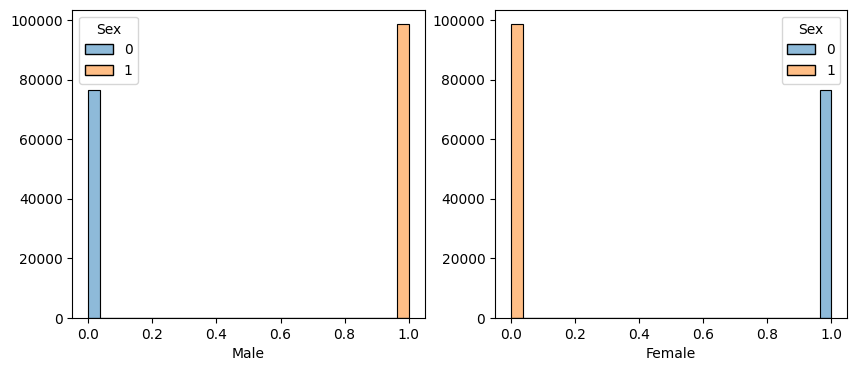

In [10]:
fig, axis= plt.subplots(1,2, figsize=(10,4))
sns.histplot(ax=axis[0], data = data_sub_isa, x = "Male",hue="Sex").set(ylabel = None)
sns.histplot(ax=axis[1], data = data_sub_isa, x = "Female",hue="Sex").set(ylabel = None)

Está correcta la variable: Sex=0 son las mujeres (Female) y Sex=1 son los hombres (Male) 

Vamos a analizar las variables por separado primero (Age, Tenure, NumOfProducts, IsActiveMember, Sex), y después analizaremos las que parecen ser una combinación de otras (Tenure_Age,Age_Tenure_product,Mem__no__Products)

**1. Análisis variables independientes: Age, Tenure, NumOfProducts, IsActiveMember, Sex**

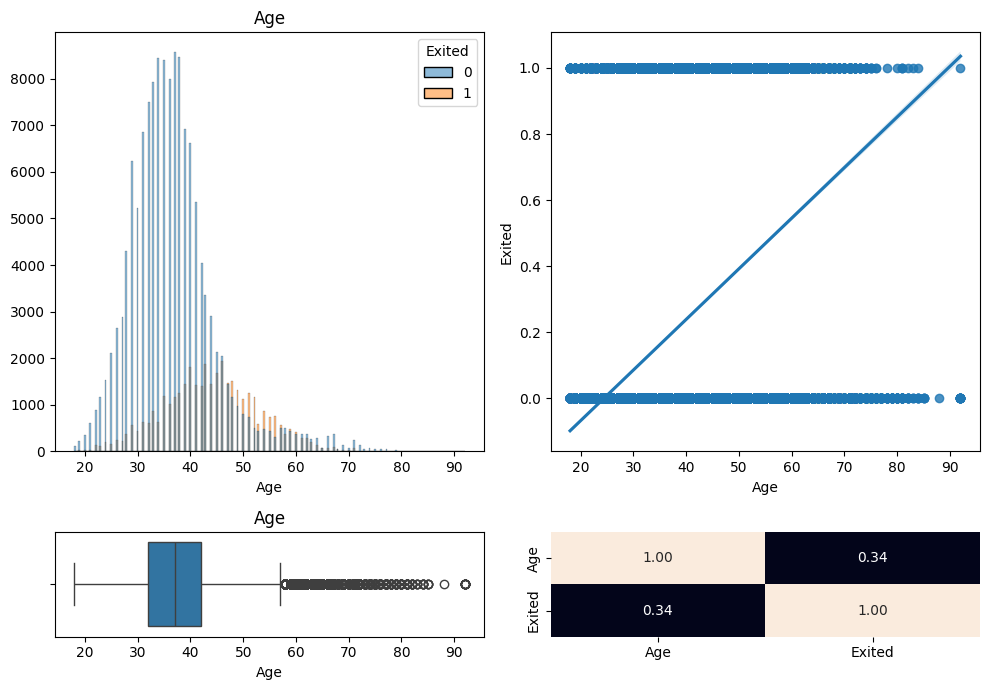

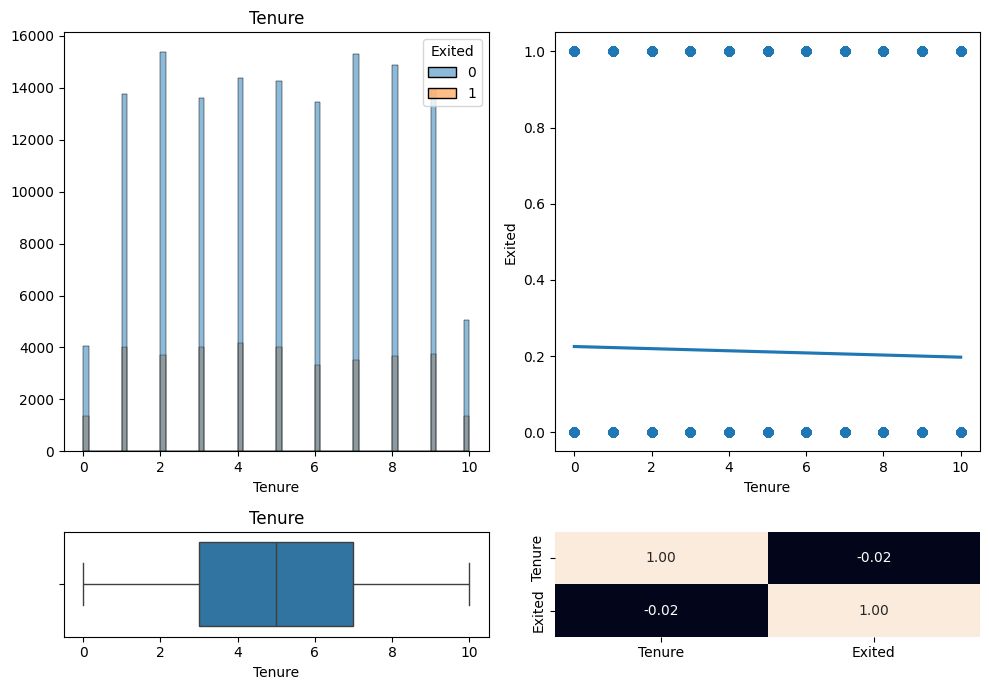

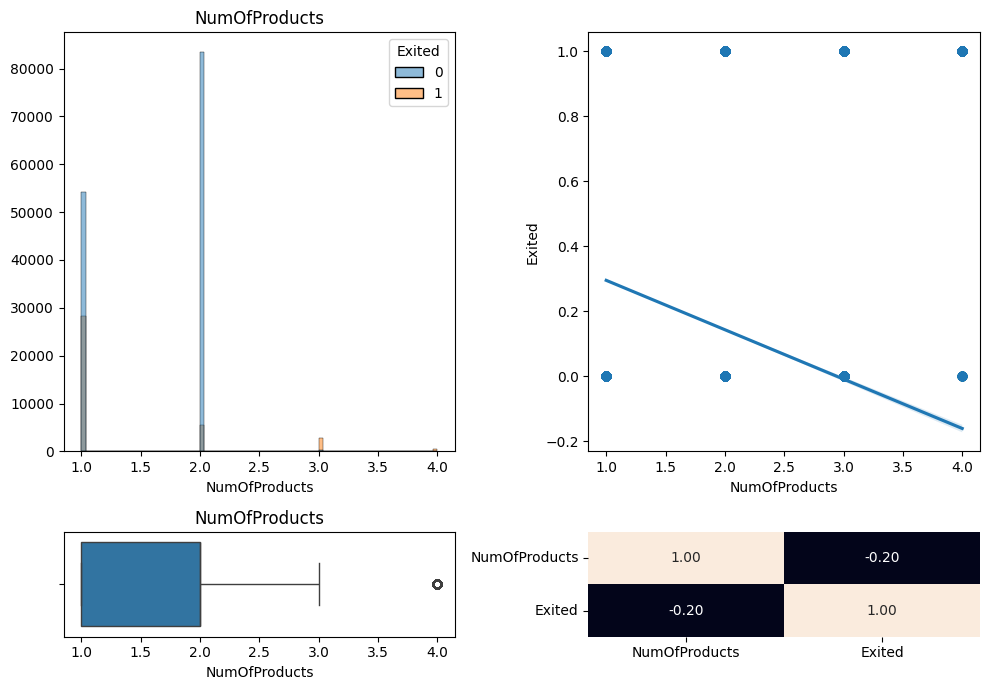

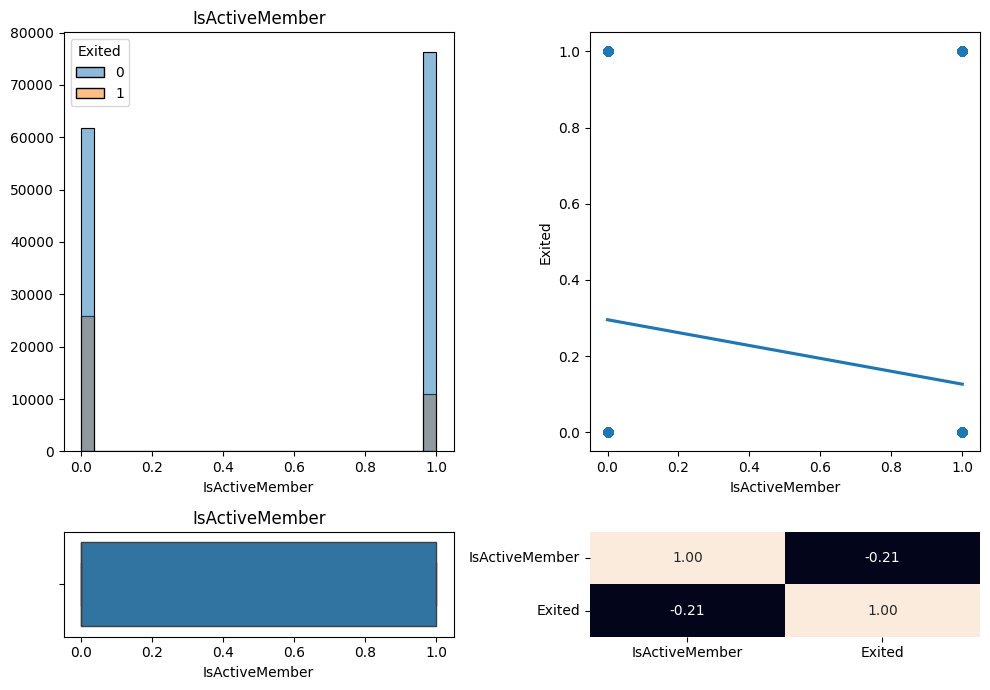

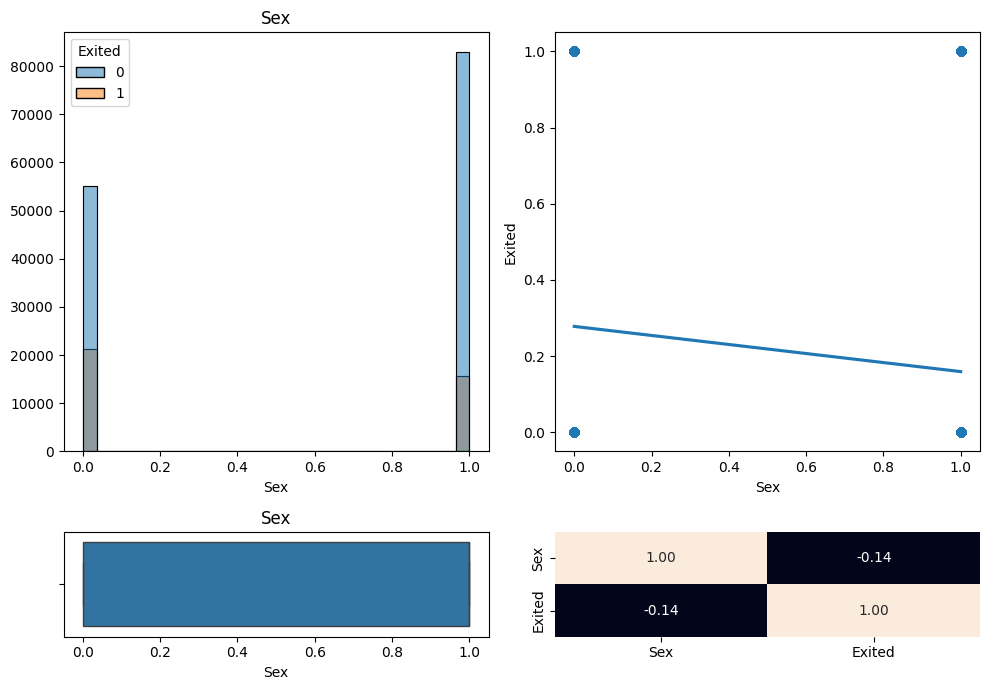

In [11]:
vars=["Age","Tenure","NumOfProducts","IsActiveMember","Sex"]
for i in range(len(vars)):
    var=vars[i]
    fig, axis = plt.subplots(2, 2, figsize = (10,7),gridspec_kw={'height_ratios': [4, 1]})
    axis[0,0].set_title(var)
    sns.histplot(ax=axis[0,0], data = data_sub_isa, x = var,hue="Exited").set(ylabel = None)
    axis[1,0].set_title(var)
    sns.regplot(data = data_sub_isa, x = var, y = "Exited",ax=axis[0,1])
    sns.boxplot(ax = axis[1,0], data = data_sub_isa, x = var)
    sns.heatmap(data_sub_isa[[var, "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
    plt.tight_layout()
    plt.show()

**ANALISIS DE LAS VARIABLES ARRIBA GRAFICADAS**

**AGE**

La variable edad concentra los atípicos en los valores altos de la variable  (por encima de los 60 años), sin embargo, podemos observar en el histograma, que en esos valores es donde se concentra el mayor porcentaje de abandonos (churn, nuestra variable objetivo *Exited*), lo que es corroborado también por la correlación positiva de 0.34 con la variable *Exited*. Por tanto, no vamos a tratar los outliers de la variable edad, y es una candidata a entrar en el modelo.

**TENURE**

La variable antigüedad, no contiene atípicos, es bastante uniforme y, además, vemos que no existe correlación ni visual (histograma) ni después en la correlación de -0.02. Esta variable es candidata a *NO* entrar en el modelo.

**NUMOFPRODUCTS**

La variable número de productos, vemos que tiene sólo 4 valores, de esos, más del 75% de los datos se concentran entre el valor 1 y 2, en la *Tabla1* vemos que el 3 concentra sólo el 1% de los datos y el 4 el 0,3%. Por tanto, no podemos tomar como significativos los % de abandono que aparecen en esos bloques. Sin embargo, sí que vemos en el histograma, que para el valor 1 el % de abandono es mucho mayor que para el valor 2. Esto también se comprueba con la correlación negativa -0.20. Esta variable es candidata a entrar en el modelo.

**ISACTIVEMEMBER**

La variable miembro activo, dicotómica, nos muestra que también tiene una correlación negativa con nuestra variable objetivo, siendo -0.21 la correlación, y visualmente podemos comprobar que el % de abandono es mayor en el valor 0 que en el 1 (miembro activo). Esta variable es candidata a entrar en el modelo.

**SEX**

La variable sexo, nos indica que, mientras que el banco tiene un mayor número de hombres (56%) (ver *Tabla2*), el % de abandono es mayor en las mujeres (28% vs 16%). Lo cual se comprueba con una correlación negativa (1 son hombres) con nuestra variable objetivo de -0.14. Esta variable es candidata a entrar en el modelo.



Tabla 1: Comprobamos la distribución de la variable NumOfProducts

In [12]:

print(pd.DataFrame({
    'Counts': data_sub_isa["NumOfProducts"].value_counts(),
    'Proportion': data_sub_isa["NumOfProducts"].value_counts() / len(y)
}))

               Counts  Proportion
NumOfProducts                    
2.0             88853    0.507769
1.0             82440    0.471121
3.0              3159    0.018053
4.0               535    0.003057


Tabla2: Porcentaje Hombres-Mujeres frente a % Churn de cada sexo:

In [13]:
percentaje=(data_sub_isa.groupby('Sex')['Exited'].count()/len(data_sub_isa['Exited']))*100
churn=(data_sub_isa.groupby("Sex")["Exited"].sum()/data_sub_isa.groupby("Sex")["Exited"].count())*100

print(pd.DataFrame({
    'Sex':["Mujer","Hombre"],
    '%': round(percentaje,2) ,
    '% Churn': round(churn,2)
    
}))

        Sex      %  % Churn
Sex                        
0     Mujer  43.67    27.80
1    Hombre  56.33    15.94


**2. Análisis variables combinadas: Tenure_Age, Age_Tenure_product, Mem__no__Products** 


Primero vemos gráficamente cómo se relacionan, después veamos si observamos alguna relación matemática entre ellas y, por último, si la correlación mejora con estas variables con respecto a las variables que la forman. Con estos pasos decidiremos si mantenemos estas variables o las descartamos para el modelo.

- **Tenure_Age**

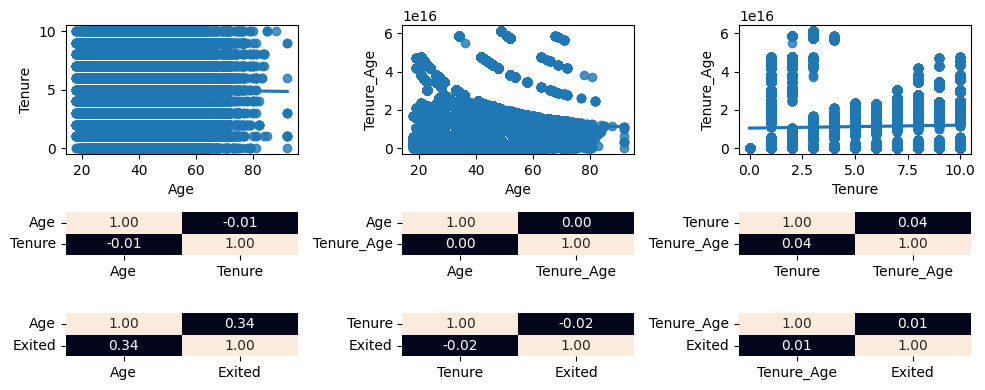

In [41]:

fig, axis = plt.subplots(3,3, figsize=(10, 4),gridspec_kw= {'height_ratios': [6, 2,2]})
sns.regplot(data = data_sub_isa, x = "Age",y="Tenure",ax=axis[0,0])
sns.regplot(data = data_sub_isa, x = "Age",y="Tenure_Age",ax=axis[0,1])
sns.regplot(data = data_sub_isa, x = "Tenure",y="Tenure_Age",ax=axis[0,2])

sns.heatmap(data_sub_isa[["Age", "Tenure"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0])
sns.heatmap(data_sub_isa[["Age", "Tenure_Age"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
sns.heatmap(data_sub_isa[["Tenure", "Tenure_Age"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2])

sns.heatmap(data_sub_isa[["Age", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,0])
sns.heatmap(data_sub_isa[["Tenure", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,1])
sns.heatmap(data_sub_isa[["Tenure_Age", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,2])


fig.tight_layout()
fig.show()


* **Age_Tenure_product**

In [ ]:

fig, axis = plt.subplots(3,3, figsize=(10, 4),gridspec_kw= {'height_ratios': [6, 2,2]})
sns.regplot(data = data_sub_isa, x = "Age",y="Tenure",ax=axis[0,0])
sns.regplot(data = data_sub_isa, x = "Age",y="Tenure_Age",ax=axis[0,1])
sns.regplot(data = data_sub_isa, x = "Tenure",y="Tenure_Age",ax=axis[0,2])

sns.heatmap(data_sub_isa[["Age", "Tenure"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0])
sns.heatmap(data_sub_isa[["Age", "Tenure_Age"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
sns.heatmap(data_sub_isa[["Tenure", "Tenure_Age"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2])

sns.heatmap(data_sub_isa[["Age", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,0])
sns.heatmap(data_sub_isa[["Tenure", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,1])
sns.heatmap(data_sub_isa[["Tenure_Age", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,2])


fig.tight_layout()
fig.show()